# ICA

This Notebook will demonstrate the Independent Component Analysis. We will take two different pictures, a face and a Chessboard, and mix them with a random mixing matrix. Afterwards, we will apply ICA to re-extract the source signals. For reasons of simplicity, we restrict ourselves to the case where the mixing matrix is quadratic.

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as scio
from scipy.optimize import minimize, NonlinearConstraint
from sklearn.decomposition import PCA

## Separation of Signals

In this section, we are going to apply the independent component analysis to signals. We will use the cosine, a sawtooth and the arctan function to generate source signals. Then, we will randomly generate a mixing matrix to get the mixed input and finally separate them back into the sources by ICA.

Note that ICA requires multiple channels of observed signals to separate it into independent sources. In our example, we use precisely as many channels as there are source signals. In practice, this means if we wanted to decompose three audio signals into three independent components, we would need three microphones located at different spots to get three sources.

In [20]:
def sawtooth(x):
    x_int = np.floor(x)
    return x - x_int

x = np.linspace(-10, 10, 100)
data = np.reshape(np.cos(x), (1, x.size))
data = np.append(data, np.reshape(sawtooth(x/2), (1, x.size)), axis=0)
data = np.append(data, np.reshape(np.arctan(x), (1, x.size)), axis=0)

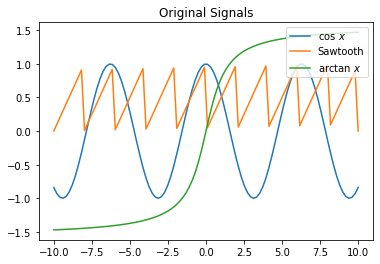

In [21]:
plt.plot(x, data[0, :])
plt.plot(x, data[1, :])
plt.plot(x, data[2, :])
plt.legend(['$\cos$ $x$', 'Sawtooth', '$\mathrm{arctan}$ $x$'], loc='upper right')
plt.title('Original Signals')
plt.show()

We are going to generate a mixing matrix A now. You can also enter your own one, just make sure it is of size 3 $\times$ 3 and ideally invertible. Afterwards, we display the input signals.

In [22]:
A = np.random.random((3, 3))
mixed_data = np.matmul(A, data)
A

array([[0.6174445 , 0.75395693, 0.88016867],
       [0.07613649, 0.23614078, 0.46059377],
       [0.0502835 , 0.34433176, 0.50127779]])

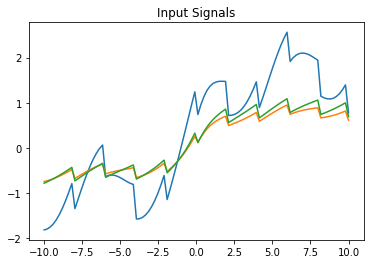

In [23]:
plt.plot(x, mixed_data[0, :])
plt.plot(x, mixed_data[1, :])
plt.plot(x, mixed_data[2, :])
plt.title('Input Signals')
plt.show()

We have to whiten the data now. For this, we use PCA to make the data univariant, centred (i.e. $E[y_i] = 0$ $\forall i$) and uncorrelated. You will see how the whitened signals look like below.

In [70]:
pca = PCA(3, whiten=True, tol=1e-5)
pca.fit(mixed_data.T)
Z = pca.transform(mixed_data.T).T
Z_plt = np.array(Z)

plt.plot(x, Z_plt[0, :])
plt.plot(x, Z_plt[1, :])
plt.plot(x, Z_plt[2, :])
plt.title('Whitened Signals')
plt.show()

ValueError: n_components=3 must be between 0 and min(n_samples, n_features)=2 with svd_solver='full'

To proceed, we have to recognize that we want to maximize the kurtosis under the constraint that the matrix $W$ must be invertible and we want $Y$ to be univariant. Therefore, we fix $| \det W | = 1$ and $\mathbb{E}[YY^T] = I$. This is done by nonlinear constraints. Remark that the kurtosis (for centred data) is given by

$$\mathrm{kurt}(\mathbf{y}_i) = \mathbb{E}[\mathbf{y}_i^4] - 3\mathbb{E}[\mathbf{y}_i^2]^2.$$

Since we fixed $1 \stackrel{!}{=} \mathbb{V}(\mathbf{y}_i) = \mathbb{E}[\mathbf{y}_i^2] - {\underbrace{\mathbb{E}[\mathbf{y}_i]}_{= 0}}  ^2$, this simplifies to

$$\mathrm{kurt} (\mathbf{y}_i) = \mathbb{E}[\mathbf{y}_i^4] - 3.$$

Since kurtosis can be both positive and negative, we will take its absolute value, i.e. maximize
$$\sum_{i = 1}^3 | \mathrm{kurt} (\mathbf{y}_i) |.$$
Since $\mathtt{scipy.optimize.minimize}$ minimizes a function, we will take the negative value such that the kurtosis is maximized.

For the constraint with the variance, we want EVERY component to have variance 1. Hence, we fix the property

$$ \sum_{i = 1}^3 \big(\mathbb{V}(\mathbf{y}_i) - 1\big)^2 = 0.$$

Fixing the determinant is easy: We just want the absolute value to be $\pm$ 1, so by subtracting 1 from it, we can tie it to 0.

In [25]:
def kurt(W) -> float:
    l = int(np.sqrt(len(W)))
    W = np.reshape(W, (l, l))
    Y = np.matmul(W, Z)
    n, _ = np.shape(Y)
    res = 0
    for i in range(l):
        res += np.abs(np.mean(np.power(Y[i, :], 4)) - 3)

    # return the negative because of maximization
    return -res

def constraint_variance_Y(W) -> float:
    l = int(np.sqrt(len(W)))
    W = np.reshape(W, (l, l))
    Y = np.matmul(W, Z)
    res = 0
    for i in range(l):
        res += (np.var([Y[i, :]]) - 1)**2
    return res

def constraint_determinant_W(W) -> float:
    l = int(np.sqrt(len(W)))
    W = np.reshape(W, (l, l))
    res = np.abs(np.linalg.det(W)) - 1
    return res

Now, we must solve the optimization problem. Therefore, we initialize our constraints and then solve the problem with the scipy.optimize.minimize() method. There is however a possibility of falling into a local minimum. To (more likely) avoid this, we could also use simulated annealing or basinhopping, but also then we would have no guarantee of falling into the global minimum. To speed up the process, the tolerance is set to 1e-5 and the optimizer will not perform more than 100 iterations.

In [26]:
constr_var = NonlinearConstraint(constraint_variance_Y, 0, 0)
constr_det = NonlinearConstraint(constraint_determinant_W, 0, 0)
constrs = [constr_var, constr_det]

# You can also use a fixed starting point here
W_0 = np.random.random((3, 3))

#W_0_ = np.reshape(W_0, (9,1))
#kurt(W_0_)
#constraint_variance_Y(W_0_)
#constraint_determinant_W(W_0_)

minimization_result = minimize(kurt, np.reshape(W_0, (9,)), method='trust-constr', constraints=constrs,
                               options={'xtol': 1e-5, 'maxiter': 100})

W = np.reshape(minimization_result.x, (3, 3))

Now, we will show the result. Note that our optimization function as well as the constraints are invariant under the multiplication of $\pm$ 1. This means that if a matrix W which maximizes the kurtosis is found, also its negative is a solution. In particular, we might also get the negative signal. Moreover, there is no possibility of choosing the order in which the signals are delivered.

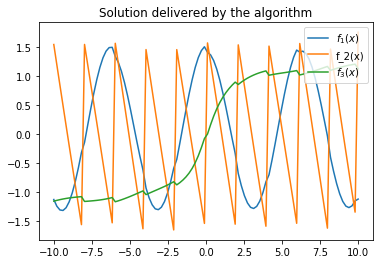

In [27]:
source = np.array(np.matmul(W, Z))

plt.plot(x, source[0, :])
plt.plot(x, source[1, :])
plt.plot(x, source[2, :])
plt.legend(['$f_1(x)$', 'f_2(x)', '$f_3(x)$'], loc='upper right')
plt.title('Solution delivered by the algorithm')
plt.show()

Let us have a look on the originial solution now. Remark the the scaling might be different because we fixed it to 1 during the optimization. There is no way to get the original scaling. Remark that also the negative functions can be obtained.

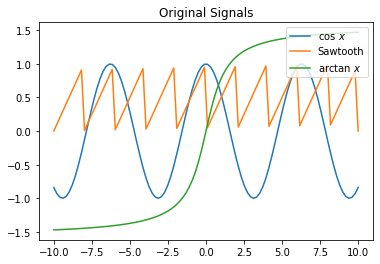

In [28]:
plt.plot(x, data[0, :])
plt.plot(x, data[1, :])
plt.plot(x, data[2, :])
plt.legend(['$\cos$ $x$', 'Sawtooth', '$\mathrm{arctan}$ $x$'], loc='upper right')
plt.title('Original Signals')
plt.show()

## Separation of Images

We are going to apple the same procedure to image separation now. First, we are going to load the data from the dataset which is also used in the exercises on PCA. It contains 144 faces in greyscale. As a second image, we are going to load the chessboard. We than reshape the two images to two row-vectors and apply ICA.

In [34]:
gall = scio.loadmat('gallery.mat')['gall'][0]
N, M = gall.item(0)[1].shape

chessboard = scio.loadmat('chess_board.mat')['chess']

You can now chose a face which you want to mix with the chess board. Don't worry if you can not decide which one you want to choose, we will just take a random index then.

In [61]:
# Random face
try:
    ind = int(input('Enter the face index (0-144): '))
except:
    ind = np.random.randint(0, 144)

if ind < 0 or ind >= 144:
    ind = np.random.randint(0, 144)
    
face = gall.item(ind)[1]

Enter the face index (0-144): 1


In [31]:
# Alternative: 2 random faces
chessboard = gall.item(np.random.randint(0, 144))[1]
face = gall.item(np.random.randint(0, 144))[1]

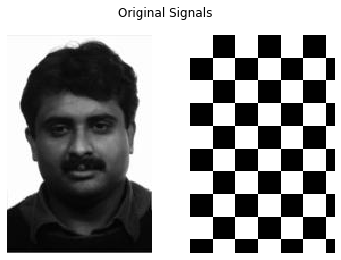

In [62]:
original_signals = np.append(np.reshape(face, (1, N*M)), np.reshape(chessboard, (1, N*M)), axis=0)

plt.subplot(1, 2, 1)
plt.imshow(np.reshape(original_signals[0, :], (N, M)), cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(np.reshape(original_signals[1, :], (N, M)), cmap='gray')
plt.axis('off')

plt.suptitle('Original Signals')
plt.show()

Again, we are going to generate the mixing matrix randomly. You may choose one yourself or just take it randomly, just make sure that it is of size 2 $\times$ 2. Afterwards, you will see the input signals.

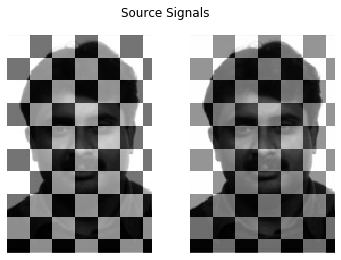

In [63]:
A = np.random.random((2, 2))
mixed_data = np.matmul(A, original_signals)

plt.subplot(1, 2, 1)
plt.imshow(np.reshape(mixed_data[0, :], (N, M)), cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(np.reshape(mixed_data[1,:], (N, M)), cmap='gray')
plt.axis('off')

plt.suptitle('Source Signals')
plt.show()

The whitened signals look as follows:

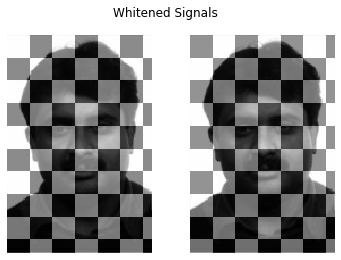

In [64]:
pca = PCA(2, whiten=True, tol=1e-5)
pca.fit(mixed_data.T)

Z = pca.transform(mixed_data.T).T

plt.subplot(1, 2, 1)
plt.imshow(np.reshape(Z[0, :], (N, M)), cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(np.reshape(Z[1, :], (N, M)), cmap='gray')
plt.axis('off')

plt.suptitle('Whitened Signals')
plt.show()

After solving the optimization problem, we get the the following result:

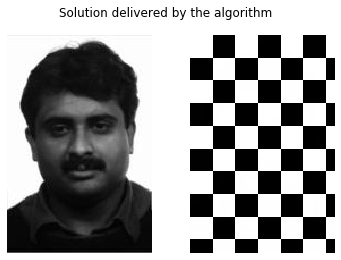

In [68]:
# one could also use a fixed starting point...
W_0 = np.random.random((2, 2))

minimization_result = minimize(kurt, np.reshape(W_0, (4,)), method='trust-constr', constraints=constrs,
                               options={'xtol': 1e-5, 'maxiter': 100})

W = np.reshape(minimization_result.x, (2, 2))

source = np.matmul(W, Z)

plt.subplot(1, 2, 1)
plt.imshow(np.reshape(source[0, :], (N, M)), cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(np.reshape(source[1, :], (N, M)), cmap='gray')
plt.axis('off')

plt.suptitle('Solution delivered by the algorithm')
plt.show()

The actual solution is the following:

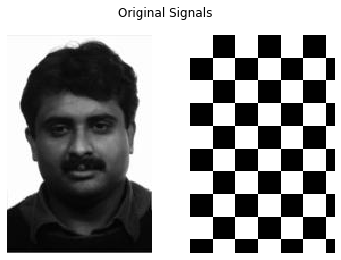

In [69]:
plt.subplot(1, 2, 1)
plt.imshow(np.reshape(original_signals[0, :], (N, M)), cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(np.reshape(original_signals[1, :], (N, M)), cmap='gray')
plt.axis('off')

plt.suptitle('Original Signals')
plt.show()

Try the image separation out with two different faces as well. To get a good result, the images should be as different as possible from one another. Since the images of two faces have a similar structure, the ICA will likely perform significantly worse in this case. To do this, just uncomment the last line in the block where the face is loaded.